XGBoost Regression - 'real-world' example: Californian Housing Dataset

https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset

In [1]:
!pip install pyGPGO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 872 kB 49.8 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19880 sha256=7d7e24417df2896cd1fa30b580ab8cad0cd1b05e991ef1aedcef0c756bae8432
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529964 sha256=2d40124b1a4f0bc9f3c4a3a58a4dd808890de61217eff57cc03ddbc699e74d89
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
# Load some default Python modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import time

from matplotlib.pyplot import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from joblib import Parallel, delayed
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from pandas_datareader import data

import warnings
import random
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Read data in pandas dataframe:
df_train =  pd.read_csv('/content/sample_data/california_housing_train.csv')


In [4]:
# List first rows:

df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [5]:
# Remove missing data:

df_train = df_train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(df_train))


New size: 17000


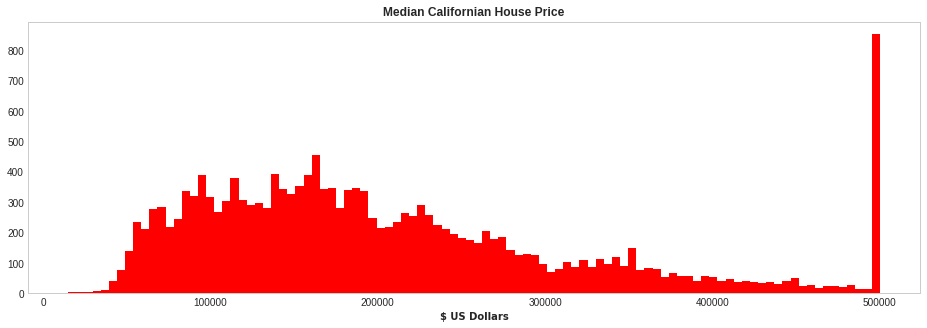

In [6]:
# Histogram fare plot:

df_train.median_house_value.hist(bins=100, figsize=(16,5), color = "red")
plt.xlabel('$ US Dollars', weight = 'bold', family = 'Arial')
plt.title('Median Californian House Price', weight = 'bold')
plt.grid(b=None)

In [7]:
y = df_train.median_house_value.values + 1e-10
y ### for supervised learning: output vector y

array([ 66900.,  80100.,  85700., ..., 103600.,  85800.,  94600.])

In [8]:
# List first rows (post-cleaning):

df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [9]:
X = df_train.drop(['median_house_value'], axis = 1)
X.head() ### for supervised learning: input matrix X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250


In [10]:
### Optimum rmse: regression model objective function is Root Mean Square Error (RMSE); 
### Should be minimized (as close to zero as possible):

y_global_orig = 0

In [11]:
### Bayesian Optimization - inputs:

obj_func = 'XGBoost'
n_test = 500 # test points

util_gp = 'CBMinimized'
util_stp = 'tCBMinimized'
n_init = 5 # random initialisations
opt = True

test_perc = 0.1
train_perc = 1 - test_perc

n_test = int(len(df_train) * test_perc)
n_train = int(len(df_train) - n_test)

eps = 1e-08

df = 3

In [12]:
### Objective function:

if obj_func == 'XGBoost': # 6-D
            
    # Constraints:
    param_lb_alpha = 0
    param_ub_alpha = 10
    
    param_lb_gamma = 0
    param_ub_gamma = 10
    
    param_lb_max_depth = 5
    param_ub_max_depth = 15
    
    param_lb_min_child_weight = 1
    param_ub_min_child_weight = 20
    
    param_lb_subsample = .5
    param_ub_subsample = 1
    
    param_lb_colsample = .1
    param_ub_colsample = 1
    
    # 6-D inputs' parameter bounds:
    param = { 'alpha':  ('cont', (param_lb_alpha, param_ub_alpha)),
         'gamma':  ('cont', (param_lb_gamma, param_ub_gamma)),     
         'max_depth':  ('int', (param_lb_max_depth, param_ub_max_depth)),
         'subsample':  ('cont', (param_lb_subsample, param_ub_subsample)),
          'min_child_weight':  ('int', (param_lb_min_child_weight, param_ub_min_child_weight)),
            'colsample': ('cont', (param_lb_colsample, param_ub_colsample))
        }
       
    # True y bounds:
    dim = 6
    
    max_iter = 30  # iterations of Bayesian optimization
    
    operator = 1 
    
    n_est = 3

In [13]:
n_start_AcqFunc = max_iter
cov_func = squaredExponential()
inverse = -1


In [14]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [15]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
    

In [16]:
### Add exact acquisition function gradient as attribute:

Beta_CBM = 1.5 #pyGPGO default parameter

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-06, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBMinimized': self.CBMinimized,
            'tCBMinimized': self.tCBMinimized
        }

        self.f = mode_dict[mode]
   
    def CBMinimized(self, tau, mean, std):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
    
    def tCBMinimized(self, tau, mean, std, nu=3.0):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (gamma + np.sqrt(Beta_CBM))

    def eval(self, y_global_orig, mean, std):
    
        return self.f(y_global_orig, mean, std, **self.params)
        
    def t_eval(self, y_global_orig, mean, std, nu=df):
    
        return self.f(y_global_orig, mean, std, nu=df, **self.params)
    

In [17]:
## GPGO_multi: Gaussian

n_start = n_start_AcqFunc

class GPGO_multi(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [18]:
## GPGO_multi_STP: Student's-t

class GPGO_multi_STP(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.t_eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [19]:
start_gp = time.time()
start_gp

1668515883.349013

In [20]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_gp_1 = GaussianProcess(cov_func, optimize=opt)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return operator * score

gp_1 = GPGO_multi(surrogate_gp_1, Acquisition_new(util_gp), f_syn_polarity1, param, n_jobs = -1) # define BayesOpt
gp_1.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_1 = gp_1.getResult()[0]
params_gp_1['max_depth'] = int(params_gp_1['max_depth'])
params_gp_1['min_child_weight'] = int(params_gp_1['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train1 = xgb.DMatrix(X_train1, y_train1)
dX_gp_test1 = xgb.DMatrix(X_test1, y_test1)
model_gp_1 = xgb.train(params_gp_1, dX_gp_train1)
pred_gp_1 = model_gp_1.predict(dX_gp_test1)

rmse_gp_1 = np.sqrt(mean_squared_error(pred_gp_1, y_test1))
rmse_gp_1

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 4.17022005  7.20324493 14.          0.65116629 16.          0.31248008]	 1.6139329892980396	 1.3678797200853317	    
init	 [ 3.96580727  3.87910741 11.          0.96776954  6.          0.71669755]	 1.4460566998267423	 1.3678797200853317	    
init	 [ 2.0445225   8.78117436  7.          0.95698101 10.          0.48762871]	 1.5755054668571844	 1.3678797200853317	    
init	 [ 9.39127789  7.78389236 14.          0.98413079  2.          0.87851823]	 1.3678797200853317	 1.3678797200853317	    
init	 [8.29146907 8.29603359 8.         0.58491521 9.         0.18851215]	 1.6515361212564685	 1.3678797200853317	    
1  	 [ 7.86951474  0.6406733  11.          0.78919481 19.          0.44182296]	 1.5598734918230905	 1.3678797200853317	 -1.8796366011232373
2  	 [8.44734445 9.05392319 8.         0.71498395 8.         0.81874323]	 1.4101379012138324	 1.3678797200853317	 -1.8848045834744194
3  	 [ 9.38886477  0.30949

48973.66312746987

In [21]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_gp_2 = GaussianProcess(cov_func, optimize=opt)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return operator * score

gp_2 = GPGO_multi(surrogate_gp_2, Acquisition_new(util_gp), f_syn_polarity2, param, n_jobs = -1) # define BayesOpt
gp_2.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_2 = gp_2.getResult()[0]
params_gp_2['max_depth'] = int(params_gp_2['max_depth'])
params_gp_2['min_child_weight'] = int(params_gp_2['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train2 = xgb.DMatrix(X_train2, y_train2)
dX_gp_test2 = xgb.DMatrix(X_test2, y_test2)
model_gp_2 = xgb.train(params_gp_2, dX_gp_train2)
pred_gp_2 = model_gp_2.predict(dX_gp_test2)

rmse_gp_2 = np.sqrt(mean_squared_error(pred_gp_2, y_test2))
rmse_gp_2

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 4.35994902  0.25926232 11.          0.97386531 12.          0.47833102]	 1.4860127799448324	 1.4169097144768446	    
init	 [ 3.30334821  2.04648634 10.          0.55997527  6.          0.71472339]	 1.4169097144768446	 1.4169097144768446	    
init	 [ 4.9856117   5.86796978  8.          0.89266757 11.          0.59158659]	 1.4327785108491773	 1.4169097144768446	    
init	 [ 4.07307832  1.76984624 13.          0.75262305  7.          0.35908193]	 1.5060418558860291	 1.4169097144768446	    
init	 [ 1.16193318  1.81727038  9.          0.79837265 19.          0.29965165]	 1.5035568847025498	 1.4169097144768446	    
1	 [9.68290573 5.74953535 8.         0.93445831 2.         0.81872709]	 1.410960072516526	 1.410960072516526	 -1.796869796467267
2  	 [ 2.17907321  8.34965852  5.          0.91660625 18.          0.97349298]	 1.4369138324355164	 1.410960072516526	 -1.7855555080987189
3  	 [ 3.86971225  8.36249

49083.90726217171

In [22]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_gp_3 = GaussianProcess(cov_func, optimize=opt)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return operator * score

gp_3 = GPGO_multi(surrogate_gp_3, Acquisition_new(util_gp), f_syn_polarity3, param, n_jobs = -1) # define BayesOpt
gp_3.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_3 = gp_3.getResult()[0]
params_gp_3['max_depth'] = int(params_gp_3['max_depth'])
params_gp_3['min_child_weight'] = int(params_gp_3['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train3 = xgb.DMatrix(X_train3, y_train3)
dX_gp_test3 = xgb.DMatrix(X_test3, y_test3)
model_gp_3 = xgb.train(params_gp_3, dX_gp_train3)
pred_gp_3 = model_gp_3.predict(dX_gp_test3)

rmse_gp_3 = np.sqrt(mean_squared_error(pred_gp_3, y_test3))
rmse_gp_3

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 5.50797903  7.08147823 13.          0.56066429 11.          0.11687321]	 1.658976916292621	 1.5210450722954243	    
init	 [ 0.40630737  2.47888297 11.          0.72040492 13.          0.23083313]	 1.6618243503452674	 1.5210450722954243	    
init	 [ 4.53172301  2.15577008 11.          0.74631796  2.          0.60296868]	 1.5210450722954243	 1.5210450722954243	    
init	 [ 2.59252447  4.15101197 13.          0.79330998  8.          0.24118096]	 1.6631154838515818	 1.5210450722954243	    
init	 [ 5.44649018  7.80314765 10.          0.62879264 18.          0.44917413]	 1.5829020757643195	 1.5210450722954243	    
1  	 [ 4.57686399  8.60533913  5.          0.93553602 12.          0.35017976]	 1.6535359388336275	 1.5210450722954243	 -1.982351216375306
2	 [7.88832343 8.95739531 8.         0.70911141 2.         0.87634458]	 1.4107278199328706	 1.4107278199328706	 -1.9895464936230571
3  	 [ 7.14373713  1.706

47953.52149217697

In [23]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_gp_4 = GaussianProcess(cov_func, optimize=opt)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return operator * score

gp_4 = GPGO_multi(surrogate_gp_4, Acquisition_new(util_gp), f_syn_polarity4, param, n_jobs = -1) # define BayesOpt
gp_4.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_4 = gp_4.getResult()[0]
params_gp_4['max_depth'] = int(params_gp_4['max_depth'])
params_gp_4['min_child_weight'] = int(params_gp_4['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train4 = xgb.DMatrix(X_train4, y_train4)
dX_gp_test4 = xgb.DMatrix(X_test4, y_test4)
model_gp_4 = xgb.train(params_gp_4, dX_gp_train4)
pred_gp_4 = model_gp_4.predict(dX_gp_test4)

rmse_gp_4 = np.sqrt(mean_squared_error(pred_gp_4, y_test4))
rmse_gp_4

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [9.67029839 5.47232249 6.         0.92781047 9.         0.72795594]	 1.4430569076610322	 1.38492629511548	    
init	 [ 2.16089496  9.76274455 12.          0.62649118  9.          0.66966679]	 1.4187070295885058	 1.38492629511548	    
init	 [ 0.05159149  5.72356491  9.          0.99170034 10.          0.10808749]	 1.6911169704550582	 1.38492629511548	    
init	 [ 3.86571283  0.44160058 10.          0.90553105 18.          0.95407958]	 1.38492629511548	 1.38492629511548	    
init	 [ 7.86305986  8.66289299  6.          0.53285477 14.          0.25117497]	 1.557078690359533	 1.38492629511548	    
1  	 [ 8.45443649  8.61014312 11.          0.83475494  1.          0.14018305]	 1.6919233052610914	 1.38492629511548	 -1.8409922629819555
2  	 [5.94148132 0.3774518  8.         0.8050532  1.         0.46608024]	 1.5132670937453574	 1.38492629511548	 -1.8814996406779754
3  	 [ 5.85683381  2.94167057 14.          

51968.025150796755

In [24]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_gp_5 = GaussianProcess(cov_func, optimize=opt)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return operator * score

gp_5 = GPGO_multi(surrogate_gp_5, Acquisition_new(util_gp), f_syn_polarity5, param, n_jobs = -1) # define BayesOpt
gp_5.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_5 = gp_5.getResult()[0]
params_gp_5['max_depth'] = int(params_gp_5['max_depth'])
params_gp_5['min_child_weight'] = int(params_gp_5['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train5 = xgb.DMatrix(X_train5, y_train5)
dX_gp_test5 = xgb.DMatrix(X_test5, y_test5)
model_gp_5 = xgb.train(params_gp_5, dX_gp_train5)
pred_gp_5 = model_gp_5.predict(dX_gp_test5)

rmse_gp_5 = np.sqrt(mean_squared_error(pred_gp_5, y_test5))
rmse_gp_5

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 2.21993171  8.70732306 11.          0.68186845 10.          0.53957007]	 1.437240644949997	 1.4314427524402045	    
init	 [ 6.11743863  7.65907856  5.          0.64840025 16.          0.82745351]	 1.4314427524402045	 1.4314427524402045	    
init	 [ 6.49458883  8.19472793  6.          0.93996852 19.          0.36647194]	 1.5681212058087062	 1.4314427524402045	    
init	 [ 6.28787909  5.7983781   6.          0.63290956 17.          0.18402673]	 1.571097153432666	 1.4314427524402045	    
init	 [8.26554249 8.33492742 9.         0.97900675 3.         0.26957319]	 1.5587909137089784	 1.4314427524402045	    
1  	 [1.95474956 1.21548467 5.         0.65548996 6.         0.3261206 ]	 1.5743532080703466	 1.4314427524402045	 -1.8139993522702675
2  	 [ 3.90043826  0.30059527 11.          0.95660877 13.          0.16396145]	 1.5638292752070921	 1.4314427524402045	 -1.834225707814148
3  	 [ 1.89102498  3.81201457

52442.3953138781

In [25]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_gp_6 = GaussianProcess(cov_func, optimize=opt)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return operator * score

gp_6 = GPGO_multi(surrogate_gp_6, Acquisition_new(util_gp), f_syn_polarity6, param, n_jobs = -1) # define BayesOpt
gp_6.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_6 = gp_6.getResult()[0]
params_gp_6['max_depth'] = int(params_gp_6['max_depth'])
params_gp_6['min_child_weight'] = int(params_gp_6['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train6 = xgb.DMatrix(X_train6, y_train6)
dX_gp_test6 = xgb.DMatrix(X_test6, y_test6)
model_gp_6 = xgb.train(params_gp_6, dX_gp_train6)
pred_gp_6 = model_gp_6.predict(dX_gp_test6)

rmse_gp_6 = np.sqrt(mean_squared_error(pred_gp_6, y_test6))
rmse_gp_6

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]	 1.5190535184382172	 1.467261064668007	    
init	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]	 1.5046102560432295	 1.467261064668007	    
init	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]	 1.467261064668007	 1.467261064668007	    
init	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]	 1.5215270866416617	 1.467261064668007	    
init	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]	 1.664748595544141	 1.467261064668007	    
1  	 [ 2.83859384  1.8954219   7.          0.66740302 13.          0.2701964 ]	 1.6613086752843393	 1.467261064668007	 -1.8804318108795361
2  	 [ 8.38264396  7.97650716 14.          0.82584689  4.          0.25017455]	 1.6700076395816645	 1.467261064668007	 -1.9069723380745227
3  	 [8.90357673 8.23982464 5.         0.

49072.41277601992

In [26]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_gp_7 = GaussianProcess(cov_func, optimize=opt)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return operator * score

gp_7 = GPGO_multi(surrogate_gp_7, Acquisition_new(util_gp), f_syn_polarity7, param, n_jobs = -1) # define BayesOpt
gp_7.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_7 = gp_7.getResult()[0]
params_gp_7['max_depth'] = int(params_gp_7['max_depth'])
params_gp_7['min_child_weight'] = int(params_gp_7['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train7 = xgb.DMatrix(X_train7, y_train7)
dX_gp_test7 = xgb.DMatrix(X_test7, y_test7)
model_gp_7 = xgb.train(params_gp_7, dX_gp_train7)
pred_gp_7 = model_gp_7.predict(dX_gp_test7)

rmse_gp_7 = np.sqrt(mean_squared_error(pred_gp_7, y_test7))
rmse_gp_7

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.76308289 7.79918792 8.         0.98911145 8.         0.98019056]	 1.3766913184499914	 1.3716193029156287	    
init	 [ 5.3849587   5.01120464 13.          0.74994125  5.          0.88192131]	 1.3716193029156287	 1.3716193029156287	    
init	 [ 3.30839249  3.9294231  12.          0.6440728  13.          0.41137564]	 1.4844760060500033	 1.3716193029156287	    
init	 [9.29528191 2.6258377  5.         0.80027446 1.         0.86616513]	 1.4553420696682378	 1.3716193029156287	    
init	 [ 1.74052764  7.90763512 14.          0.7244129   4.          0.77536887]	 1.4144357133522163	 1.3716193029156287	    
1  	 [3.70351083 4.59092978 6.         0.70937861 6.         0.814213  ]	 1.438878549232204	 1.3716193029156287	 -1.7405981076628683
2  	 [ 8.27276329  5.80705371  6.          0.6575149  16.          0.66596626]	 1.4515297103144826	 1.3716193029156287	 -1.7442269719925638
3  	 [ 8.97988092  8.79483413 14.

51149.14051411869

In [27]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_gp_8 = GaussianProcess(cov_func, optimize=opt)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return operator * score

gp_8 = GPGO_multi(surrogate_gp_8, Acquisition_new(util_gp), f_syn_polarity8, param, n_jobs = -1) # define BayesOpt
gp_8.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_8 = gp_8.getResult()[0]
params_gp_8['max_depth'] = int(params_gp_8['max_depth'])
params_gp_8['min_child_weight'] = int(params_gp_8['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train8 = xgb.DMatrix(X_train8, y_train8)
dX_gp_test8 = xgb.DMatrix(X_test8, y_test8)
model_gp_8 = xgb.train(params_gp_8, dX_gp_train8)
pred_gp_8 = model_gp_8.predict(dX_gp_test8)

rmse_gp_8 = np.sqrt(mean_squared_error(pred_gp_8, y_test8))
rmse_gp_8

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]	 1.4345420020169601	 1.380205361584031	    
init	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]	 1.389083518296823	 1.380205361584031	    
init	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]	 1.4546623776895313	 1.380205361584031	    
init	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]	 1.400955898397293	 1.380205361584031	    
init	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]	 1.380205361584031	 1.380205361584031	    
1  	 [4.42022545 5.48487111 9.         0.97165909 3.         0.63617522]	 1.392033230213678	 1.380205361584031	 -1.7295508545626948
2  	 [ 4.42530022  8.86662399 12.          0.55390756 19.          0.26906902]	 1.4535137998644672	 1.380205361584031	 -1.7254648777096182
3  	 [ 9.08237751  2.49680746  

51834.38822315281

In [28]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_gp_9 = GaussianProcess(cov_func, optimize=opt)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return operator * score

gp_9 = GPGO_multi(surrogate_gp_9, Acquisition_new(util_gp), f_syn_polarity9, param, n_jobs = -1) # define BayesOpt
gp_9.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_9 = gp_9.getResult()[0]
params_gp_9['max_depth'] = int(params_gp_9['max_depth'])
params_gp_9['min_child_weight'] = int(params_gp_9['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train9 = xgb.DMatrix(X_train9, y_train9)
dX_gp_test9 = xgb.DMatrix(X_test9, y_test9)
model_gp_9 = xgb.train(params_gp_9, dX_gp_train9)
pred_gp_9 = model_gp_9.predict(dX_gp_test9)

rmse_gp_9 = np.sqrt(mean_squared_error(pred_gp_9, y_test9))
rmse_gp_9

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 0.10374154  5.01874592 11.          0.50377155  2.          0.29670281]	 1.5577132784573362	 1.3722986758568372	    
init	 [ 4.18508181  2.48101168 13.          0.69794293  2.          0.25009871]	 1.557988294847283	 1.3722986758568372	    
init	 [ 8.78559086  9.50964032 13.          0.98395204 11.          0.90820641]	 1.3722986758568372	 1.3722986758568372	    
init	 [ 6.66898973  5.47837783  6.          0.97165345 12.          0.72499481]	 1.4672635070842577	 1.3722986758568372	    
init	 [ 8.24870465  4.65668475 13.          0.68760467  9.          0.98502332]	 1.3809301169879382	 1.3722986758568372	    
1  	 [6.73714319 2.39608167 5.         0.58130302 3.         0.163077  ]	 1.685094312684032	 1.3722986758568372	 -1.7997361827262606
2  	 [9.23885705 0.0495141  9.         0.5847098  7.         0.79832927]	 1.4005164561828327	 1.3722986758568372	 -1.8463733701183187
3  	 [ 3.67545472  4.7814531

48075.00995818073

In [29]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_gp_10 = GaussianProcess(cov_func, optimize=opt)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return operator * score

gp_10 = GPGO_multi(surrogate_gp_10, Acquisition_new(util_gp), f_syn_polarity10, param, n_jobs = -1) # define BayesOpt
gp_10.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_10 = gp_10.getResult()[0]
params_gp_10['max_depth'] = int(params_gp_10['max_depth'])
params_gp_10['min_child_weight'] = int(params_gp_10['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train10 = xgb.DMatrix(X_train10, y_train10)
dX_gp_test10 = xgb.DMatrix(X_test10, y_test10)
model_gp_10 = xgb.train(params_gp_10, dX_gp_train10)
pred_gp_10 = model_gp_10.predict(dX_gp_test10)

rmse_gp_10 = np.sqrt(mean_squared_error(pred_gp_10, y_test10))
rmse_gp_10

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 7.71320643  0.20751949  5.          0.72150747 17.          0.12265456]	 1.5966621860966772	 1.3816576901725537	    
init	 [ 7.0920801   2.65566127 13.          0.57518893 17.          0.83494165]	 1.3816576901725537	 1.3816576901725537	    
init	 [ 3.36071584  8.90816531  6.          0.86087766 15.          0.75469196]	 1.4046956914996547	 1.3816576901725537	    
init	 [ 5.40880931  1.31458152  8.          0.57108502 14.          0.62551123]	 1.4201195466728969	 1.3816576901725537	    
init	 [1.82631436 8.26082248 6.         0.80888349 5.         0.15900694]	 1.5985040415985665	 1.3816576901725537	    
1  	 [8.31989768 3.09778055 7.         0.64798085 3.         0.98471878]	 1.3861520034074002	 1.3816576901725537	 -1.816876679252568
2  	 [ 3.05837423  0.98670899 11.          0.63714741 18.          0.46809298]	 1.4421785552543012	 1.3816576901725537	 -1.797557742883037
3  	 [1.0517383  0.29626986 

51078.029167094595

In [30]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_gp_11 = GaussianProcess(cov_func, optimize=opt)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return operator * score

gp_11 = GPGO_multi(surrogate_gp_11, Acquisition_new(util_gp), f_syn_polarity11, param, n_jobs = -1) # define BayesOpt
gp_11.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_11 = gp_11.getResult()[0]
params_gp_11['max_depth'] = int(params_gp_11['max_depth'])
params_gp_11['min_child_weight'] = int(params_gp_11['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train11 = xgb.DMatrix(X_train11, y_train11)
dX_gp_test11 = xgb.DMatrix(X_test11, y_test11)
model_gp_11 = xgb.train(params_gp_11, dX_gp_train11)
pred_gp_11 = model_gp_11.predict(dX_gp_test11)

rmse_gp_11 = np.sqrt(mean_squared_error(pred_gp_11, y_test11))
rmse_gp_11

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.80269689  0.19475241  6.          0.59705781 13.          0.47818324]	 1.4816591577946832	 1.4105425145194488	    
init	 [ 4.85427098  0.12780815  5.          0.91309068 14.          0.86571558]	 1.426706936764755	 1.4105425145194488	    
init	 [ 7.2996447   1.08736072 10.          0.92857712 18.          0.66910061]	 1.4105425145194488	 1.4105425145194488	    
init	 [ 0.20483613  1.16737269  7.          0.57895615 16.          0.83644782]	 1.4183397861714337	 1.4105425145194488	    
init	 [ 3.44624491  3.18798797 14.          0.54197657 15.          0.63958906]	 1.4201459936126652	 1.4105425145194488	    
1  	 [9.77136617 6.6548802  7.         0.51036649 9.         0.81011527]	 1.4198592349317078	 1.4105425145194488	 -1.7505322748060679
2	 [ 0.59719728  4.15307516 11.          0.66501717  3.          0.95537014]	 1.3788509866175809	 1.3788509866175809	 -1.7486043509277462
3  	 [ 8.79191945  9.92

53943.20510701921

In [31]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_gp_12 = GaussianProcess(cov_func, optimize=opt)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return operator * score

gp_12 = GPGO_multi(surrogate_gp_12, Acquisition_new(util_gp), f_syn_polarity12, param, n_jobs = -1) # define BayesOpt
gp_12.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_12 = gp_12.getResult()[0]
params_gp_12['max_depth'] = int(params_gp_12['max_depth'])
params_gp_12['min_child_weight'] = int(params_gp_12['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train12 = xgb.DMatrix(X_train12, y_train12)
dX_gp_test12 = xgb.DMatrix(X_test12, y_test12)
model_gp_12 = xgb.train(params_gp_12, dX_gp_train12)
pred_gp_12 = model_gp_12.predict(dX_gp_test12)

rmse_gp_12 = np.sqrt(mean_squared_error(pred_gp_12, y_test12))
rmse_gp_12

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [1.54162842 7.40049697 6.         0.54321714 4.         0.11311747]	 1.6495881989170076	 1.4161885061290391	    
init	 [ 9.18747008  9.00714854 14.          0.97847467 11.          0.35544552]	 1.5149964971320231	 1.4161885061290391	    
init	 [ 6.06083184  9.44225136 14.          0.95626942  5.          0.56910342]	 1.4459275331997625	 1.4161885061290391	    
init	 [ 5.52037633  4.85377414  7.          0.97886436 17.          0.78810441]	 1.4161885061290391	 1.4161885061290391	    
init	 [ 0.20809798  1.35210178  5.          0.65494879 16.          0.36062811]	 1.527260055706503	 1.4161885061290391	    
1  	 [9.46555822 8.57190559 5.         0.50164398 5.         0.71992807]	 1.4518180624203443	 1.4161885061290391	 -1.852983923291504
2  	 [ 3.78385301  2.21923666 12.          0.57141407  8.          0.55842631]	 1.45369553613684	 1.4161885061290391	 -1.840716953953196
3  	 [ 4.11623908  6.6334167   

50898.07950989245

In [32]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_gp_13 = GaussianProcess(cov_func, optimize=opt)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return operator * score

gp_13 = GPGO_multi(surrogate_gp_13, Acquisition_new(util_gp), f_syn_polarity13, param, n_jobs = -1) # define BayesOpt
gp_13.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_13 = gp_13.getResult()[0]
params_gp_13['max_depth'] = int(params_gp_13['max_depth'])
params_gp_13['min_child_weight'] = int(params_gp_13['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train13 = xgb.DMatrix(X_train13, y_train13)
dX_gp_test13 = xgb.DMatrix(X_test13, y_test13)
model_gp_13 = xgb.train(params_gp_13, dX_gp_train13)
pred_gp_13 = model_gp_13.predict(dX_gp_test13)

rmse_gp_13 = np.sqrt(mean_squared_error(pred_gp_13, y_test13))
rmse_gp_13

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 7.77702411  2.3754122  11.          0.94649135 13.          0.7827256 ]	 1.3814631927491285	 1.3814631927491285	    
init	 [ 7.51661514  6.07343344 11.          0.69402149 11.          0.13153287]	 1.6959297564173816	 1.3814631927491285	    
init	 [ 2.98449471  0.58512492 10.          0.73579614 12.          0.33065195]	 1.5246886192220386	 1.3814631927491285	    
init	 [ 3.47581215  0.0941277  11.          0.86143432  8.          0.58454932]	 1.4185759644827896	 1.3814631927491285	    
init	 [ 4.70137857  6.24432527 10.          0.8149145  18.          0.10784416]	 1.6944183605438403	 1.3814631927491285	    
1  	 [1.51786663 9.25994479 9.         0.99792981 2.         0.61199673]	 1.4182805465760875	 1.3814631927491285	 -1.8967599092136285
2  	 [6.93463528 1.25795731 8.         0.92695971 3.         0.9534311 ]	 1.3892303833521897	 1.3814631927491285	 -1.8710278358986512
3  	 [ 1.27154032  7.56256

52056.02569720847

In [33]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_gp_14 = GaussianProcess(cov_func, optimize=opt)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return operator * score

gp_14 = GPGO_multi(surrogate_gp_14, Acquisition_new(util_gp), f_syn_polarity14, param, n_jobs = -1) # define BayesOpt
gp_14.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_14 = gp_14.getResult()[0]
params_gp_14['max_depth'] = int(params_gp_14['max_depth'])
params_gp_14['min_child_weight'] = int(params_gp_14['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train14 = xgb.DMatrix(X_train14, y_train14)
dX_gp_test14 = xgb.DMatrix(X_test14, y_test14)
model_gp_14 = xgb.train(params_gp_14, dX_gp_train14)
pred_gp_14 = model_gp_14.predict(dX_gp_test14)

rmse_gp_14 = np.sqrt(mean_squared_error(pred_gp_14, y_test14))
rmse_gp_14

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 5.13943344  7.73165052 12.          0.6831412  11.          0.37876233]	 1.5555798623190729	 1.4024696810470139	    
init	 [ 9.57603739  5.13116712 14.          0.76959997 12.          0.71328228]	 1.4192714165556448	 1.4024696810470139	    
init	 [5.34950319 2.47493539 5.         0.50293689 6.         0.29706373]	 1.6043764718675084	 1.4024696810470139	    
init	 [ 2.94506579  3.45329697  8.          0.87620946 14.          0.9783044 ]	 1.4024696810470139	 1.4024696810470139	    
init	 [ 1.11811929  1.73004086  5.          0.73745288 12.          0.20586008]	 1.6112248980856712	 1.4024696810470139	    
1  	 [ 6.50637223  2.67617722 14.          0.53562507  1.          0.16862152]	 1.6022414457029215	 1.4024696810470139	 -1.863127309757673
2  	 [ 5.83528891  2.63149599 12.          0.61005677 19.          0.2879488 ]	 1.5884724030482242	 1.4024696810470139	 -1.8800502441294862
3  	 [0.07739536 3.94

52328.253611520566

In [34]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_gp_15 = GaussianProcess(cov_func, optimize=opt)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return operator * score

gp_15 = GPGO_multi(surrogate_gp_15, Acquisition_new(util_gp), f_syn_polarity15, param, n_jobs = -1) # define BayesOpt
gp_15.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_15 = gp_15.getResult()[0]
params_gp_15['max_depth'] = int(params_gp_15['max_depth'])
params_gp_15['min_child_weight'] = int(params_gp_15['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train15 = xgb.DMatrix(X_train15, y_train15)
dX_gp_test15 = xgb.DMatrix(X_test15, y_test15)
model_gp_15 = xgb.train(params_gp_15, dX_gp_train15)
pred_gp_15 = model_gp_15.predict(dX_gp_test15)

rmse_gp_15 = np.sqrt(mean_squared_error(pred_gp_15, y_test15))
rmse_gp_15

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 8.48817697  1.78895925 12.          0.55549316  8.          0.93397854]	 1.376451715987612	 1.376451715987612	    
init	 [ 0.24953032  8.22298097 12.          0.62494951 11.          0.12924598]	 1.5659547455717522	 1.376451715987612	    
init	 [ 5.02017228  5.50882771 11.          0.85295832 19.          0.13548008]	 1.5651600836199522	 1.376451715987612	    
init	 [2.0023081  9.98543403 7.         0.6295772  2.         0.526127  ]	 1.4164354656135685	 1.376451715987612	    
init	 [ 5.09715306  9.45038417 11.          0.7388277  16.          0.22739973]	 1.5662872595805275	 1.376451715987612	    
1  	 [ 0.29158961  4.9949242  12.          0.89124583  3.          0.67554049]	 1.3814014024038652	 1.376451715987612	 -1.8376159820035736
2  	 [2.60517447 0.82584036 7.         0.6107555  4.         0.25427784]	 1.5377909292253389	 1.376451715987612	 -1.8141373172596964
3  	 [ 1.91126037  0.99517267  5. 

50629.339378690864

In [35]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_gp_16 = GaussianProcess(cov_func, optimize=opt)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return operator * score

gp_16 = GPGO_multi(surrogate_gp_16, Acquisition_new(util_gp), f_syn_polarity16, param, n_jobs = -1) # define BayesOpt
gp_16.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_16 = gp_16.getResult()[0]
params_gp_16['max_depth'] = int(params_gp_16['max_depth'])
params_gp_16['min_child_weight'] = int(params_gp_16['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train16 = xgb.DMatrix(X_train16, y_train16)
dX_gp_test16 = xgb.DMatrix(X_test16, y_test16)
model_gp_16 = xgb.train(params_gp_16, dX_gp_train16)
pred_gp_16 = model_gp_16.predict(dX_gp_test16)

rmse_gp_16 = np.sqrt(mean_squared_error(pred_gp_16, y_test16))
rmse_gp_16

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [2.23291079 5.23163341 6.         0.65430839 5.         0.30077285]	 1.5445131891906443	 1.5311877282940682	    
init	 [6.88726162 1.63731425 7.         0.97050543 2.         0.25392012]	 1.5397173057708042	 1.5311877282940682	    
init	 [ 5.94328983  5.6393473   5.          0.67602695 19.          0.42538144]	 1.5311877282940682	 1.5311877282940682	    
init	 [ 0.88741148  3.08148142 14.          0.56043938  9.          0.27515386]	 1.545084837896393	 1.5311877282940682	    
init	 [ 2.74631586  1.30996118 11.          0.52160786  8.          0.27956463]	 1.5455911570787226	 1.5311877282940682	    
1	 [ 7.8937256   1.5972923  14.          0.61610774 17.          0.78739284]	 1.416411889040415	 1.416411889040415	 -1.887456575656208
2  	 [ 9.65014948  7.07834667 14.          0.88748515  2.          0.43513691]	 1.5248044056830778	 1.416411889040415	 -1.8629013652185893
3  	 [ 9.80741348  8.90144788 14.

51608.0671923665

In [36]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_gp_17 = GaussianProcess(cov_func, optimize=opt)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return operator * score

gp_17 = GPGO_multi(surrogate_gp_17, Acquisition_new(util_gp), f_syn_polarity17, param, n_jobs = -1) # define BayesOpt
gp_17.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_17 = gp_17.getResult()[0]
params_gp_17['max_depth'] = int(params_gp_17['max_depth'])
params_gp_17['min_child_weight'] = int(params_gp_17['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train17 = xgb.DMatrix(X_train17, y_train17)
dX_gp_test17 = xgb.DMatrix(X_test17, y_test17)
model_gp_17 = xgb.train(params_gp_17, dX_gp_train17)
pred_gp_17 = model_gp_17.predict(dX_gp_test17)

rmse_gp_17 = np.sqrt(mean_squared_error(pred_gp_17, y_test17))
rmse_gp_17

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 2.94665003  5.30586756 11.          0.94443241 14.          0.80828691]	 1.432187192078573	 1.432187192078573	    
init	 [ 6.56333522  6.37520896 12.          0.81487881 18.          0.42203224]	 1.4945483449196877	 1.432187192078573	    
init	 [ 9.45683187  0.6004468  11.          0.5171566  10.          0.53881211]	 1.4548205565954722	 1.432187192078573	    
init	 [2.72705857 1.19063434 6.         0.74176431 6.         0.10101151]	 1.6432713945852762	 1.432187192078573	    
init	 [ 4.77631812  5.24671297 13.          0.66254476 19.          0.36708086]	 1.5567864797674738	 1.432187192078573	    
1  	 [ 0.65702322  5.79284078 13.          0.75136902  1.          0.30306068]	 1.5652619856245054	 1.432187192078573	 -1.8340942930778237
2  	 [8.79462978 7.51560605 6.         0.76312232 8.         0.57156636]	 1.4624094820459992	 1.432187192078573	 -1.848490018851201
3	 [0.65992542 7.03112384 5.       

49738.50593465154

In [37]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_gp_18 = GaussianProcess(cov_func, optimize=opt)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return operator * score

gp_18 = GPGO_multi(surrogate_gp_18, Acquisition_new(util_gp), f_syn_polarity18, param, n_jobs = -1) # define BayesOpt
gp_18.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_18 = gp_18.getResult()[0]
params_gp_18['max_depth'] = int(params_gp_18['max_depth'])
params_gp_18['min_child_weight'] = int(params_gp_18['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train18 = xgb.DMatrix(X_train18, y_train18)
dX_gp_test18 = xgb.DMatrix(X_test18, y_test18)
model_gp_18 = xgb.train(params_gp_18, dX_gp_train18)
pred_gp_18 = model_gp_18.predict(dX_gp_test18)

rmse_gp_18 = np.sqrt(mean_squared_error(pred_gp_18, y_test18))
rmse_gp_18

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [6.50374242 5.05453374 6.         0.59092011 3.         0.28357516]	 1.554201920032415	 1.4181769530522108	    
init	 [0.11506734 4.26891483 9.         0.81785956 5.         0.63489043]	 1.4181769530522108	 1.4181769530522108	    
init	 [ 2.8861259   6.35547834 11.          0.64267955 14.          0.27877092]	 1.5553172299320928	 1.4181769530522108	    
init	 [6.57189031 6.99655629 8.         0.63235896 4.         0.52894035]	 1.4757071646006859	 1.4181769530522108	    
init	 [ 6.66600348  2.11312037 14.          0.74363461  4.          0.73174558]	 1.4231733496037333	 1.4181769530522108	    
1  	 [ 8.67093232  0.11649132  5.          0.92962202 15.          0.53672863]	 1.4839064811956693	 1.4181769530522108	 -1.8123785198891071
2	 [ 7.2764983   0.11744451 14.          0.65239666 17.          0.99049521]	 1.3810139389147824	 1.3810139389147824	 -1.813226880499402
3  	 [ 6.9243088   2.24175244  9.   

49057.83447142187

In [38]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_gp_19 = GaussianProcess(cov_func, optimize=opt)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return operator * score

gp_19 = GPGO_multi(surrogate_gp_19, Acquisition_new(util_gp), f_syn_polarity19, param, n_jobs = -1) # define BayesOpt
gp_19.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_19 = gp_19.getResult()[0]
params_gp_19['max_depth'] = int(params_gp_19['max_depth'])
params_gp_19['min_child_weight'] = int(params_gp_19['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train19 = xgb.DMatrix(X_train19, y_train19)
dX_gp_test19 = xgb.DMatrix(X_test19, y_test19)
model_gp_19 = xgb.train(params_gp_19, dX_gp_train19)
pred_gp_19 = model_gp_19.predict(dX_gp_test19)

rmse_gp_19 = np.sqrt(mean_squared_error(pred_gp_19, y_test19))
rmse_gp_19

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 0.97533602  7.61249717 13.          0.85765469 11.          0.39830191]	 1.4075337339770704	 1.4075337339770704	    
init	 [ 0.82999565  6.71977081  6.          0.50407413 19.          0.67209466]	 1.4228132434714993	 1.4075337339770704	    
init	 [ 2.15923256  5.49027432 12.          0.52588686 10.          0.20235326]	 1.6084741621894145	 1.4075337339770704	    
init	 [4.99659267 1.52108422 6.         0.73481085 4.         0.71949465]	 1.4198106118164695	 1.4075337339770704	    
init	 [ 3.72927156  9.46160045  5.          0.80554614 18.          0.97708466]	 1.4218628552782113	 1.4075337339770704	    
1	 [ 8.33060043  1.42030563  8.          0.92863724 14.          0.78606141]	 1.3842780004279849	 1.3842780004279849	 -1.7729595199916246
2	 [ 9.87536409  7.17591217 14.          0.99713522 17.          0.55460731]	 1.3794846103893081	 1.3794846103893081	 -1.7588504735761097
3  	 [ 9.05225624  3.600

48750.904339736284

In [39]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_gp_20 = GaussianProcess(cov_func, optimize=opt)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return operator * score

gp_20 = GPGO_multi(surrogate_gp_20, Acquisition_new(util_gp), f_syn_polarity20, param, n_jobs = -1) # define BayesOpt
gp_20.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_20 = gp_20.getResult()[0]
params_gp_20['max_depth'] = int(params_gp_20['max_depth'])
params_gp_20['min_child_weight'] = int(params_gp_20['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train20 = xgb.DMatrix(X_train20, y_train20)
dX_gp_test20 = xgb.DMatrix(X_test20, y_test20)
model_gp_20 = xgb.train(params_gp_20, dX_gp_train20)
pred_gp_20 = model_gp_20.predict(dX_gp_test20)

rmse_gp_20 = np.sqrt(mean_squared_error(pred_gp_20, y_test20))
rmse_gp_20

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 5.88130801  8.97713728 14.          0.81074445  8.          0.95540649]	 1.3748447855907977	 1.3748447855907977	    
init	 [6.72865655 0.41173329 8.         0.6361582  7.         0.76174061]	 1.4185133726703796	 1.3748447855907977	    
init	 [ 4.77387703  8.66202323 10.          0.51833215  7.          0.10123387]	 1.6439786774737961	 1.3748447855907977	    
init	 [ 5.75489985  4.74524381  8.          0.78084343 15.          0.26643049]	 1.534878770114387	 1.3748447855907977	    
init	 [ 4.53444     4.47342833  8.          0.91974896 18.          0.35997552]	 1.5336412960522285	 1.3748447855907977	    
1  	 [ 7.96566073  7.15509535  7.          0.79906691 11.          0.34132075]	 1.536147862834937	 1.3748447855907977	 -1.842250818820827
2  	 [ 1.72798052  9.03285612 13.          0.50351094 19.          0.11416888]	 1.6447091013479738	 1.3748447855907977	 -1.8459939585102993
3  	 [ 1.96661701  1.73

50163.48769005427

In [40]:
end_gp = time.time()
end_gp

time_gp = end_gp - start_gp
time_gp

start_stp = time.time()
start_stp

1668516501.6746619

In [41]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_stp_1 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return operator * score

stp_1 = GPGO_multi_STP(surrogate_stp_1, Acquisition_new(util_stp), f_syn_polarity1, param, n_jobs = -1) # Define BayesOpt
stp_1.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_1 = stp_1.getResult()[0]
params_stp_1['max_depth'] = int(params_stp_1['max_depth'])
params_stp_1['min_child_weight'] = int(params_stp_1['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train1 = xgb.DMatrix(X_train1, y_train1)
dX_stp_test1 = xgb.DMatrix(X_test1, y_test1)
model_stp_1 = xgb.train(params_stp_1, dX_stp_train1)
pred_stp_1 = model_stp_1.predict(dX_stp_test1)

rmse_stp_1 = np.sqrt(mean_squared_error(pred_stp_1, y_test1))
rmse_stp_1

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 4.17022005  7.20324493 14.          0.65116629 16.          0.31248008]	 1.6139329892980396	 1.3678797200853317	    
init	 [ 3.96580727  3.87910741 11.          0.96776954  6.          0.71669755]	 1.4460566998267423	 1.3678797200853317	    
init	 [ 2.0445225   8.78117436  7.          0.95698101 10.          0.48762871]	 1.5755054668571844	 1.3678797200853317	    
init	 [ 9.39127789  7.78389236 14.          0.98413079  2.          0.87851823]	 1.3678797200853317	 1.3678797200853317	    
init	 [8.29146907 8.29603359 8.         0.58491521 9.         0.18851215]	 1.6515361212564685	 1.3678797200853317	    
1  	 [ 7.86951474  0.6406733  11.          0.78919481 19.          0.44182296]	 1.5598734918230905	 1.3678797200853317	 -1.87963068384897
2  	 [8.44734445 9.05392319 8.         0.71498395 8.         0.81874323]	 1.4101379012138324	 1.3678797200853317	 -1.8848045067377421
3  	 [ 9.38886477  0.3094900

48973.66312746987

In [42]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_stp_2 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return operator * score

stp_2 = GPGO_multi_STP(surrogate_stp_2, Acquisition_new(util_stp), f_syn_polarity2, param, n_jobs = -1) # Define BayesOpt
stp_2.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_2 = stp_2.getResult()[0]
params_stp_2['max_depth'] = int(params_stp_2['max_depth'])
params_stp_2['min_child_weight'] = int(params_stp_2['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train2 = xgb.DMatrix(X_train2, y_train2)
dX_stp_test2 = xgb.DMatrix(X_test2, y_test2)
model_stp_2 = xgb.train(params_stp_2, dX_stp_train2)
pred_stp_2 = model_stp_2.predict(dX_stp_test2)

rmse_stp_2 = np.sqrt(mean_squared_error(pred_stp_2, y_test2))
rmse_stp_2

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 4.35994902  0.25926232 11.          0.97386531 12.          0.47833102]	 1.4860127799448324	 1.4169097144768446	    
init	 [ 3.30334821  2.04648634 10.          0.55997527  6.          0.71472339]	 1.4169097144768446	 1.4169097144768446	    
init	 [ 4.9856117   5.86796978  8.          0.89266757 11.          0.59158659]	 1.4327785108491773	 1.4169097144768446	    
init	 [ 4.07307832  1.76984624 13.          0.75262305  7.          0.35908193]	 1.5060418558860291	 1.4169097144768446	    
init	 [ 1.16193318  1.81727038  9.          0.79837265 19.          0.29965165]	 1.5035568847025498	 1.4169097144768446	    
1	 [9.68290573 5.74953535 8.         0.93445831 2.         0.81872709]	 1.410960072516526	 1.410960072516526	 -1.7976777494104939
2  	 [ 2.17907321  8.34965852  5.          0.91660625 18.          0.97349298]	 1.4369138324355164	 1.410960072516526	 -1.7861865110662176
3  	 [ 3.86971225  8.3624

48632.65431892592

In [43]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_stp_3 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return operator * score

stp_3 = GPGO_multi_STP(surrogate_stp_3, Acquisition_new(util_stp), f_syn_polarity3, param, n_jobs = -1) # Define BayesOpt
stp_3.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_3 = stp_3.getResult()[0]
params_stp_3['max_depth'] = int(params_stp_3['max_depth'])
params_stp_3['min_child_weight'] = int(params_stp_3['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train3 = xgb.DMatrix(X_train3, y_train3)
dX_stp_test3 = xgb.DMatrix(X_test3, y_test3)
model_stp_3 = xgb.train(params_stp_3, dX_stp_train3)
pred_stp_3 = model_stp_3.predict(dX_stp_test3)

rmse_stp_3 = np.sqrt(mean_squared_error(pred_stp_3, y_test3))
rmse_stp_3

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 5.50797903  7.08147823 13.          0.56066429 11.          0.11687321]	 1.658976916292621	 1.5210450722954243	    
init	 [ 0.40630737  2.47888297 11.          0.72040492 13.          0.23083313]	 1.6618243503452674	 1.5210450722954243	    
init	 [ 4.53172301  2.15577008 11.          0.74631796  2.          0.60296868]	 1.5210450722954243	 1.5210450722954243	    
init	 [ 2.59252447  4.15101197 13.          0.79330998  8.          0.24118096]	 1.6631154838515818	 1.5210450722954243	    
init	 [ 5.44649018  7.80314765 10.          0.62879264 18.          0.44917413]	 1.5829020757643195	 1.5210450722954243	    
1  	 [1.56262424 9.7795241  5.         0.91450054 5.         0.53102391]	 1.5403180511194614	 1.5210450722954243	 -1.9823453361028804
2  	 [ 7.69133691  0.25025283 10.          0.52101543 12.          0.10383979]	 1.658882601400044	 1.5210450722954243	 -1.9666959778069126
3  	 [ 7.38032831  9.9

49067.25831672984

In [44]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_stp_4 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return operator * score

stp_4 = GPGO_multi_STP(surrogate_stp_4, Acquisition_new(util_stp), f_syn_polarity4, param, n_jobs = -1) # Define BayesOpt
stp_4.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_4 = stp_4.getResult()[0]
params_stp_4['max_depth'] = int(params_stp_4['max_depth'])
params_stp_4['min_child_weight'] = int(params_stp_4['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train4 = xgb.DMatrix(X_train4, y_train4)
dX_stp_test4 = xgb.DMatrix(X_test4, y_test4)
model_stp_4 = xgb.train(params_stp_4, dX_stp_train4)
pred_stp_4 = model_stp_4.predict(dX_stp_test4)

rmse_stp_4 = np.sqrt(mean_squared_error(pred_stp_4, y_test4))
rmse_stp_4

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [9.67029839 5.47232249 6.         0.92781047 9.         0.72795594]	 1.4430569076610322	 1.38492629511548	    
init	 [ 2.16089496  9.76274455 12.          0.62649118  9.          0.66966679]	 1.4187070295885058	 1.38492629511548	    
init	 [ 0.05159149  5.72356491  9.          0.99170034 10.          0.10808749]	 1.6911169704550582	 1.38492629511548	    
init	 [ 3.86571283  0.44160058 10.          0.90553105 18.          0.95407958]	 1.38492629511548	 1.38492629511548	    
init	 [ 7.86305986  8.66289299  6.          0.53285477 14.          0.25117497]	 1.557078690359533	 1.38492629511548	    
1  	 [ 8.45443649  8.61014312 11.          0.83475494  1.          0.14018305]	 1.6919233052610914	 1.38492629511548	 -1.8409941020501068
2  	 [ 0.90674561  6.32290535 11.          0.94435129  1.          0.40346185]	 1.5093686588345598	 1.38492629511548	 -1.8814975092017188
3  	 [ 7.37481669  1.69273565 11.    

52578.14757171591

In [45]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_stp_5 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return operator * score

stp_5 = GPGO_multi_STP(surrogate_stp_5, Acquisition_new(util_stp), f_syn_polarity5, param, n_jobs = -1) # Define BayesOpt
stp_5.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_5 = stp_5.getResult()[0]
params_stp_5['max_depth'] = int(params_stp_5['max_depth'])
params_stp_5['min_child_weight'] = int(params_stp_5['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train5 = xgb.DMatrix(X_train5, y_train5)
dX_stp_test5 = xgb.DMatrix(X_test5, y_test5)
model_stp_5 = xgb.train(params_stp_5, dX_stp_train5)
pred_stp_5 = model_stp_5.predict(dX_stp_test5)

rmse_stp_5 = np.sqrt(mean_squared_error(pred_stp_5, y_test5))
rmse_stp_5

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 2.21993171  8.70732306 11.          0.68186845 10.          0.53957007]	 1.437240644949997	 1.4314427524402045	    
init	 [ 6.11743863  7.65907856  5.          0.64840025 16.          0.82745351]	 1.4314427524402045	 1.4314427524402045	    
init	 [ 6.49458883  8.19472793  6.          0.93996852 19.          0.36647194]	 1.5681212058087062	 1.4314427524402045	    
init	 [ 6.28787909  5.7983781   6.          0.63290956 17.          0.18402673]	 1.571097153432666	 1.4314427524402045	    
init	 [8.26554249 8.33492742 9.         0.97900675 3.         0.26957319]	 1.5587909137089784	 1.4314427524402045	    
1  	 [1.95474956 1.21548467 5.         0.65548996 6.         0.3261206 ]	 1.5743532080703466	 1.4314427524402045	 -1.8242517075926645
2  	 [ 3.90043826  0.30059527 11.          0.95660877 13.          0.16396145]	 1.5638292752070921	 1.4314427524402045	 -1.8428398489586688
3  	 [ 1.89102498  3.8120145

50524.07081134296

In [46]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_stp_6 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=int(min_child_weight),
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = 'reg:squarederror', eval_metric = 'rmse')
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return operator * score

stp_6 = GPGO_multi_STP(surrogate_stp_6, Acquisition_new(util_stp), f_syn_polarity6, param, n_jobs = -1) # Define BayesOpt
stp_6.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_6 = stp_6.getResult()[0]
params_stp_6['max_depth'] = int(params_stp_6['max_depth'])
params_stp_6['min_child_weight'] = int(params_stp_6['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train6 = xgb.DMatrix(X_train6, y_train6)
dX_stp_test6 = xgb.DMatrix(X_test6, y_test6)
model_stp_6 = xgb.train(params_stp_6, dX_stp_train6)
pred_stp_6 = model_stp_6.predict(dX_stp_test6)

rmse_stp_6 = np.sqrt(mean_squared_error(pred_stp_6, y_test6))
rmse_stp_6

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]	 1.5190535184382172	 1.467261064668007	    
init	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]	 1.5046102560432295	 1.467261064668007	    
init	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]	 1.467261064668007	 1.467261064668007	    
init	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]	 1.5215270866416617	 1.467261064668007	    
init	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]	 1.664748595544141	 1.467261064668007	    
1  	 [ 2.83859384  1.8954219   7.          0.66740302 13.          0.2701964 ]	 1.6613086752843393	 1.467261064668007	 -1.8809590321647591
2  	 [ 8.38264396  7.97650716 14.          0.82584689  4.          0.25017455]	 1.6700076395816645	 1.467261064668007	 -1.9074834157046385
3  	 [8.90357673 8.23982464 5.         0.

47889.96454564933

In [47]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_stp_7 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return operator * score

stp_7 = GPGO_multi_STP(surrogate_stp_7, Acquisition_new(util_stp), f_syn_polarity7, param, n_jobs = -1) # Define BayesOpt
stp_7.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_7 = stp_7.getResult()[0]
params_stp_7['max_depth'] = int(params_stp_7['max_depth'])
params_stp_7['min_child_weight'] = int(params_stp_7['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train7 = xgb.DMatrix(X_train7, y_train7)
dX_stp_test7 = xgb.DMatrix(X_test7, y_test7)
model_stp_7 = xgb.train(params_stp_7, dX_stp_train7)
pred_stp_7 = model_stp_7.predict(dX_stp_test7)

rmse_stp_7 = np.sqrt(mean_squared_error(pred_stp_7, y_test7))
rmse_stp_7

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.76308289 7.79918792 8.         0.98911145 8.         0.98019056]	 1.3766913184499914	 1.3716193029156287	    
init	 [ 5.3849587   5.01120464 13.          0.74994125  5.          0.88192131]	 1.3716193029156287	 1.3716193029156287	    
init	 [ 3.30839249  3.9294231  12.          0.6440728  13.          0.41137564]	 1.4844760060500033	 1.3716193029156287	    
init	 [9.29528191 2.6258377  5.         0.80027446 1.         0.86616513]	 1.4553420696682378	 1.3716193029156287	    
init	 [ 1.74052764  7.90763512 14.          0.7244129   4.          0.77536887]	 1.4144357133522163	 1.3716193029156287	    
1  	 [3.43305102 3.00339076 8.         0.71322679 4.         0.33322219]	 1.5452875922440117	 1.3716193029156287	 -1.7405980283985367
2  	 [ 8.27276329  5.80705371  6.          0.6575149  16.          0.66596626]	 1.4515297103144826	 1.3716193029156287	 -1.7668420033843495
3  	 [ 8.97988092  8.79483413 14

51748.11340223583

In [48]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_stp_8 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return operator * score

stp_8 = GPGO_multi_STP(surrogate_stp_8, Acquisition_new(util_stp), f_syn_polarity8, param, n_jobs = -1) # Define BayesOpt
stp_8.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_8 = stp_8.getResult()[0]
params_stp_8['max_depth'] = int(params_stp_8['max_depth'])
params_stp_8['min_child_weight'] = int(params_stp_8['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train8 = xgb.DMatrix(X_train8, y_train8)
dX_stp_test8 = xgb.DMatrix(X_test8, y_test8)
model_stp_8 = xgb.train(params_stp_8, dX_stp_train8)
pred_stp_8 = model_stp_8.predict(dX_stp_test8)

rmse_stp_8 = np.sqrt(mean_squared_error(pred_stp_8, y_test8))
rmse_stp_8

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]	 1.4345420020169601	 1.380205361584031	    
init	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]	 1.389083518296823	 1.380205361584031	    
init	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]	 1.4546623776895313	 1.380205361584031	    
init	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]	 1.400955898397293	 1.380205361584031	    
init	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]	 1.380205361584031	 1.380205361584031	    
1  	 [4.42022545 5.48487111 9.         0.97165909 3.         0.63617522]	 1.392033230213678	 1.380205361584031	 -1.7295508085277722
2  	 [ 4.42530022  8.86662399 12.          0.55390756 19.          0.26906902]	 1.4535137998644672	 1.380205361584031	 -1.7254649296527114
3  	 [ 9.08237751  2.49680746  

50941.770500572056

In [49]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_stp_9 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return operator * score

stp_9 = GPGO_multi_STP(surrogate_stp_9, Acquisition_new(util_stp), f_syn_polarity9, param, n_jobs = -1) # Define BayesOpt
stp_9.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_9 = stp_9.getResult()[0]
params_stp_9['max_depth'] = int(params_stp_9['max_depth'])
params_stp_9['min_child_weight'] = int(params_stp_9['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train9 = xgb.DMatrix(X_train9, y_train9)
dX_stp_test9 = xgb.DMatrix(X_test9, y_test9)
model_stp_9 = xgb.train(params_stp_9, dX_stp_train9)
pred_stp_9 = model_stp_9.predict(dX_stp_test9)

rmse_stp_9 = np.sqrt(mean_squared_error(pred_stp_9, y_test9))
rmse_stp_9

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 0.10374154  5.01874592 11.          0.50377155  2.          0.29670281]	 1.5577132784573362	 1.3722986758568372	    
init	 [ 4.18508181  2.48101168 13.          0.69794293  2.          0.25009871]	 1.557988294847283	 1.3722986758568372	    
init	 [ 8.78559086  9.50964032 13.          0.98395204 11.          0.90820641]	 1.3722986758568372	 1.3722986758568372	    
init	 [ 6.66898973  5.47837783  6.          0.97165345 12.          0.72499481]	 1.4672635070842577	 1.3722986758568372	    
init	 [ 8.24870465  4.65668475 13.          0.68760467  9.          0.98502332]	 1.3809301169879382	 1.3722986758568372	    
1  	 [6.73714319 2.39608167 5.         0.58130302 3.         0.163077  ]	 1.685094312684032	 1.3722986758568372	 -1.7997376178846658
2  	 [ 8.16285902  8.43489929  9.          0.96605421 10.          0.79940153]	 1.3900654366200929	 1.3722986758568372	 -1.846373370177001
3  	 [ 3.67545472  4.78

48559.456405630066

In [50]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_stp_10 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return operator * score

stp_10 = GPGO_multi_STP(surrogate_stp_10, Acquisition_new(util_stp), f_syn_polarity10, param, n_jobs = -1) # Define BayesOpt
stp_10.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_10 = stp_10.getResult()[0]
params_stp_10['max_depth'] = int(params_stp_10['max_depth'])
params_stp_10['min_child_weight'] = int(params_stp_10['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train10 = xgb.DMatrix(X_train10, y_train10)
dX_stp_test10 = xgb.DMatrix(X_test10, y_test10)
model_stp_10 = xgb.train(params_stp_10, dX_stp_train10)
pred_stp_10 = model_stp_10.predict(dX_stp_test10)

rmse_stp_10 = np.sqrt(mean_squared_error(pred_stp_10, y_test10))
rmse_stp_10

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 7.71320643  0.20751949  5.          0.72150747 17.          0.12265456]	 1.5966621860966772	 1.3816576901725537	    
init	 [ 7.0920801   2.65566127 13.          0.57518893 17.          0.83494165]	 1.3816576901725537	 1.3816576901725537	    
init	 [ 3.36071584  8.90816531  6.          0.86087766 15.          0.75469196]	 1.4046956914996547	 1.3816576901725537	    
init	 [ 5.40880931  1.31458152  8.          0.57108502 14.          0.62551123]	 1.4201195466728969	 1.3816576901725537	    
init	 [1.82631436 8.26082248 6.         0.80888349 5.         0.15900694]	 1.5985040415985665	 1.3816576901725537	    
1  	 [8.31989768 3.09778055 7.         0.64798085 3.         0.98471878]	 1.3861520034074002	 1.3816576901725537	 -1.8168738492171195
2  	 [ 3.05837423  0.98670899 11.          0.63714741 18.          0.46809298]	 1.4421785552543012	 1.3816576901725537	 -1.7975575656231404
3  	 [1.0517383  0.2962698

52414.09097368018

In [51]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_stp_11 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return operator * score

stp_11 = GPGO_multi_STP(surrogate_stp_11, Acquisition_new(util_stp), f_syn_polarity11, param, n_jobs = -1) # Define BayesOpt
stp_11.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_11 = stp_11.getResult()[0]
params_stp_11['max_depth'] = int(params_stp_11['max_depth'])
params_stp_11['min_child_weight'] = int(params_stp_11['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train11 = xgb.DMatrix(X_train11, y_train11)
dX_stp_test11 = xgb.DMatrix(X_test11, y_test11)
model_stp_11 = xgb.train(params_stp_11, dX_stp_train11)
pred_stp_11 = model_stp_11.predict(dX_stp_test11)

rmse_stp_11 = np.sqrt(mean_squared_error(pred_stp_11, y_test11))
rmse_stp_11

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.80269689  0.19475241  6.          0.59705781 13.          0.47818324]	 1.4816591577946832	 1.4105425145194488	    
init	 [ 4.85427098  0.12780815  5.          0.91309068 14.          0.86571558]	 1.426706936764755	 1.4105425145194488	    
init	 [ 7.2996447   1.08736072 10.          0.92857712 18.          0.66910061]	 1.4105425145194488	 1.4105425145194488	    
init	 [ 0.20483613  1.16737269  7.          0.57895615 16.          0.83644782]	 1.4183397861714337	 1.4105425145194488	    
init	 [ 3.44624491  3.18798797 14.          0.54197657 15.          0.63958906]	 1.4201459936126652	 1.4105425145194488	    
1  	 [9.77136617 6.6548802  7.         0.51036649 9.         0.81011527]	 1.4198592349317078	 1.4105425145194488	 -1.7513445085733506
2	 [ 0.59719728  4.15307516 11.          0.66501717  3.          0.95537014]	 1.3788509866175809	 1.3788509866175809	 -1.749301806271078
3  	 [ 8.79191945  9.923

52673.060950772546

In [52]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_stp_12 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return operator * score

stp_12 = GPGO_multi_STP(surrogate_stp_12, Acquisition_new(util_stp), f_syn_polarity12, param, n_jobs = -1) # Define BayesOpt
stp_12.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_12 = stp_12.getResult()[0]
params_stp_12['max_depth'] = int(params_stp_12['max_depth'])
params_stp_12['min_child_weight'] = int(params_stp_12['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train12 = xgb.DMatrix(X_train12, y_train12)
dX_stp_test12 = xgb.DMatrix(X_test12, y_test12)
model_stp_12 = xgb.train(params_stp_12, dX_stp_train12)
pred_stp_12 = model_stp_12.predict(dX_stp_test12)

rmse_stp_12 = np.sqrt(mean_squared_error(pred_stp_12, y_test12))
rmse_stp_12

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [1.54162842 7.40049697 6.         0.54321714 4.         0.11311747]	 1.6495881989170076	 1.4161885061290391	    
init	 [ 9.18747008  9.00714854 14.          0.97847467 11.          0.35544552]	 1.5149964971320231	 1.4161885061290391	    
init	 [ 6.06083184  9.44225136 14.          0.95626942  5.          0.56910342]	 1.4459275331997625	 1.4161885061290391	    
init	 [ 5.52037633  4.85377414  7.          0.97886436 17.          0.78810441]	 1.4161885061290391	 1.4161885061290391	    
init	 [ 0.20809798  1.35210178  5.          0.65494879 16.          0.36062811]	 1.527260055706503	 1.4161885061290391	    
1  	 [9.46555822 8.57190559 5.         0.50164398 5.         0.71992807]	 1.4518180624203443	 1.4161885061290391	 -1.8529846351735686
2  	 [ 3.78385301  2.21923666 12.          0.57141407  8.          0.55842631]	 1.45369553613684	 1.4161885061290391	 -1.8407168568075796
3  	 [ 7.48458025  0.82585105

51641.83516817326

In [53]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_stp_13 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return operator * score

stp_13 = GPGO_multi_STP(surrogate_stp_13, Acquisition_new(util_stp), f_syn_polarity13, param, n_jobs = -1) # Define BayesOpt
stp_13.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_13 = stp_13.getResult()[0]
params_stp_13['max_depth'] = int(params_stp_13['max_depth'])
params_stp_13['min_child_weight'] = int(params_stp_13['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train13 = xgb.DMatrix(X_train13, y_train13)
dX_stp_test13 = xgb.DMatrix(X_test13, y_test13)
model_stp_13 = xgb.train(params_stp_13, dX_stp_train13)
pred_stp_13 = model_stp_13.predict(dX_stp_test13)

rmse_stp_13 = np.sqrt(mean_squared_error(pred_stp_13, y_test13))
rmse_stp_13

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 7.77702411  2.3754122  11.          0.94649135 13.          0.7827256 ]	 1.3814631927491285	 1.3814631927491285	    
init	 [ 7.51661514  6.07343344 11.          0.69402149 11.          0.13153287]	 1.6959297564173816	 1.3814631927491285	    
init	 [ 2.98449471  0.58512492 10.          0.73579614 12.          0.33065195]	 1.5246886192220386	 1.3814631927491285	    
init	 [ 3.47581215  0.0941277  11.          0.86143432  8.          0.58454932]	 1.4185759644827896	 1.3814631927491285	    
init	 [ 4.70137857  6.24432527 10.          0.8149145  18.          0.10784416]	 1.6944183605438403	 1.3814631927491285	    
1  	 [1.51786663 9.25994479 9.         0.99792981 2.         0.61199673]	 1.4182805465760875	 1.3814631927491285	 -1.8966771907888085
2  	 [6.93463528 1.25795731 8.         0.92695971 3.         0.9534311 ]	 1.3892303833521897	 1.3814631927491285	 -1.8710188474354388
3  	 [ 1.27154032  7.56256

49640.64566227302

In [54]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_stp_14 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return operator * score

stp_14 = GPGO_multi_STP(surrogate_stp_14, Acquisition_new(util_stp), f_syn_polarity14, param, n_jobs = -1) # Define BayesOpt
stp_14.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_14 = stp_14.getResult()[0]
params_stp_14['max_depth'] = int(params_stp_14['max_depth'])
params_stp_14['min_child_weight'] = int(params_stp_14['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train14 = xgb.DMatrix(X_train14, y_train14)
dX_stp_test14 = xgb.DMatrix(X_test14, y_test14)
model_stp_14 = xgb.train(params_stp_14, dX_stp_train14)
pred_stp_14 = model_stp_14.predict(dX_stp_test14)

rmse_stp_14 = np.sqrt(mean_squared_error(pred_stp_14, y_test14))
rmse_stp_14

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 5.13943344  7.73165052 12.          0.6831412  11.          0.37876233]	 1.5555798623190729	 1.4024696810470139	    
init	 [ 9.57603739  5.13116712 14.          0.76959997 12.          0.71328228]	 1.4192714165556448	 1.4024696810470139	    
init	 [5.34950319 2.47493539 5.         0.50293689 6.         0.29706373]	 1.6043764718675084	 1.4024696810470139	    
init	 [ 2.94506579  3.45329697  8.          0.87620946 14.          0.9783044 ]	 1.4024696810470139	 1.4024696810470139	    
init	 [ 1.11811929  1.73004086  5.          0.73745288 12.          0.20586008]	 1.6112248980856712	 1.4024696810470139	    
1  	 [ 6.50637223  2.67617722 14.          0.53562507  1.          0.16862152]	 1.6022414457029215	 1.4024696810470139	 -1.8631381203609434
2  	 [ 5.83528891  2.63149599 12.          0.61005677 19.          0.2879488 ]	 1.5884724030482242	 1.4024696810470139	 -1.8800485317786328
3  	 [0.07739536 3.9

52952.65453107279

In [55]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_stp_15 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return operator * score

stp_15 = GPGO_multi_STP(surrogate_stp_15, Acquisition_new(util_stp), f_syn_polarity15, param, n_jobs = -1) # Define BayesOpt
stp_15.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_15 = stp_15.getResult()[0]
params_stp_15['max_depth'] = int(params_stp_15['max_depth'])
params_stp_15['min_child_weight'] = int(params_stp_15['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train15 = xgb.DMatrix(X_train15, y_train15)
dX_stp_test15 = xgb.DMatrix(X_test15, y_test15)
model_stp_15 = xgb.train(params_stp_15, dX_stp_train15)
pred_stp_15 = model_stp_15.predict(dX_stp_test15)

rmse_stp_15 = np.sqrt(mean_squared_error(pred_stp_15, y_test15))
rmse_stp_15

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 8.48817697  1.78895925 12.          0.55549316  8.          0.93397854]	 1.376451715987612	 1.376451715987612	    
init	 [ 0.24953032  8.22298097 12.          0.62494951 11.          0.12924598]	 1.5659547455717522	 1.376451715987612	    
init	 [ 5.02017228  5.50882771 11.          0.85295832 19.          0.13548008]	 1.5651600836199522	 1.376451715987612	    
init	 [2.0023081  9.98543403 7.         0.6295772  2.         0.526127  ]	 1.4164354656135685	 1.376451715987612	    
init	 [ 5.09715306  9.45038417 11.          0.7388277  16.          0.22739973]	 1.5662872595805275	 1.376451715987612	    
1  	 [ 0.29158961  4.9949242  12.          0.89124583  3.          0.67554049]	 1.3814014024038652	 1.376451715987612	 -1.8376160054228818
2  	 [2.60517447 0.82584036 7.         0.6107555  4.         0.25427784]	 1.5377909292253389	 1.376451715987612	 -1.8141371967836355
3  	 [ 1.91126037  0.99517267  5. 

50204.88938566787

In [56]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_stp_16 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return operator * score

stp_16 = GPGO_multi_STP(surrogate_stp_16, Acquisition_new(util_stp), f_syn_polarity16, param, n_jobs = -1) # Define BayesOpt
stp_16.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_16 = stp_16.getResult()[0]
params_stp_16['max_depth'] = int(params_stp_16['max_depth'])
params_stp_16['min_child_weight'] = int(params_stp_16['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train16 = xgb.DMatrix(X_train16, y_train16)
dX_stp_test16 = xgb.DMatrix(X_test16, y_test16)
model_stp_16 = xgb.train(params_stp_16, dX_stp_train16)
pred_stp_16 = model_stp_16.predict(dX_stp_test16)

rmse_stp_16 = np.sqrt(mean_squared_error(pred_stp_16, y_test16))
rmse_stp_16

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [2.23291079 5.23163341 6.         0.65430839 5.         0.30077285]	 1.5445131891906443	 1.5311877282940682	    
init	 [6.88726162 1.63731425 7.         0.97050543 2.         0.25392012]	 1.5397173057708042	 1.5311877282940682	    
init	 [ 5.94328983  5.6393473   5.          0.67602695 19.          0.42538144]	 1.5311877282940682	 1.5311877282940682	    
init	 [ 0.88741148  3.08148142 14.          0.56043938  9.          0.27515386]	 1.545084837896393	 1.5311877282940682	    
init	 [ 2.74631586  1.30996118 11.          0.52160786  8.          0.27956463]	 1.5455911570787226	 1.5311877282940682	    
1	 [ 7.8937256   1.5972923  14.          0.61610774 17.          0.78739284]	 1.416411889040415	 1.416411889040415	 -1.8874966286438968
2  	 [ 9.65014948  7.07834667 14.          0.88748515  2.          0.43513691]	 1.5248044056830778	 1.416411889040415	 -1.862906436174381
3  	 [ 9.80741348  8.90144788 14.

50482.78878121671

In [57]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_stp_17 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return operator * score

stp_17 = GPGO_multi_STP(surrogate_stp_17, Acquisition_new(util_stp), f_syn_polarity17, param, n_jobs = -1) # Define BayesOpt
stp_17.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_17 = stp_17.getResult()[0]
params_stp_17['max_depth'] = int(params_stp_17['max_depth'])
params_stp_17['min_child_weight'] = int(params_stp_17['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train17 = xgb.DMatrix(X_train17, y_train17)
dX_stp_test17 = xgb.DMatrix(X_test17, y_test17)
model_stp_17 = xgb.train(params_stp_17, dX_stp_train17)
pred_stp_17 = model_stp_17.predict(dX_stp_test17)

rmse_stp_17 = np.sqrt(mean_squared_error(pred_stp_17, y_test17))
rmse_stp_17

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 2.94665003  5.30586756 11.          0.94443241 14.          0.80828691]	 1.432187192078573	 1.432187192078573	    
init	 [ 6.56333522  6.37520896 12.          0.81487881 18.          0.42203224]	 1.4945483449196877	 1.432187192078573	    
init	 [ 9.45683187  0.6004468  11.          0.5171566  10.          0.53881211]	 1.4548205565954722	 1.432187192078573	    
init	 [2.72705857 1.19063434 6.         0.74176431 6.         0.10101151]	 1.6432713945852762	 1.432187192078573	    
init	 [ 4.77631812  5.24671297 13.          0.66254476 19.          0.36708086]	 1.5567864797674738	 1.432187192078573	    
1  	 [ 0.65702322  5.79284078 13.          0.75136902  1.          0.30306068]	 1.5652619856245054	 1.432187192078573	 -1.8407331718329434
2  	 [8.79462978 7.51560605 6.         0.76312232 8.         0.57156636]	 1.4624094820459992	 1.432187192078573	 -1.854083255165627
3	 [0.65992542 7.03112384 5.       

49312.766580775264

In [58]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_stp_18 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_18, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return operator * score

stp_18 = GPGO_multi_STP(surrogate_stp_18, Acquisition_new(util_stp), f_syn_polarity18, param, n_jobs = -1) # Define BayesOpt
stp_18.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_18 = stp_18.getResult()[0]
params_stp_18['max_depth'] = int(params_stp_18['max_depth'])
params_stp_18['min_child_weight'] = int(params_stp_18['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train18 = xgb.DMatrix(X_train18, y_train18)
dX_stp_test18 = xgb.DMatrix(X_test18, y_test18)
model_stp_18 = xgb.train(params_stp_18, dX_stp_train18)
pred_stp_18 = model_stp_18.predict(dX_stp_test18)

rmse_stp_18 = np.sqrt(mean_squared_error(pred_stp_18, y_test18))
rmse_stp_18

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [6.50374242 5.05453374 6.         0.59092011 3.         0.28357516]	 1.6322360469477801	 1.459078835901506	    
init	 [0.11506734 4.26891483 9.         0.81785956 5.         0.63489043]	 1.459078835901506	 1.459078835901506	    
init	 [ 2.8861259   6.35547834 11.          0.64267955 14.          0.27877092]	 1.6286856942256722	 1.459078835901506	    
init	 [6.57189031 6.99655629 8.         0.63235896 4.         0.52894035]	 1.5014828773258142	 1.459078835901506	    
init	 [ 6.66600348  2.11312037 14.          0.74363461  4.          0.73174558]	 1.4595033750139994	 1.459078835901506	    
1  	 [ 8.67093232  0.11649132  5.          0.92962202 15.          0.53672863]	 1.5426478637399241	 1.459078835901506	 -1.8781257079098892
2	 [ 7.2764983   0.11744451 14.          0.65239666 17.          0.99049521]	 1.3686205630592922	 1.3686205630592922	 -1.8800655574403358
3  	 [ 6.9243088   2.24175244  9.        

47814.5922880461

In [59]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_stp_19 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return operator * score

stp_19 = GPGO_multi_STP(surrogate_stp_19, Acquisition_new(util_stp), f_syn_polarity19, param, n_jobs = -1) # Define BayesOpt
stp_19.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_19 = stp_19.getResult()[0]
params_stp_19['max_depth'] = int(params_stp_19['max_depth'])
params_stp_19['min_child_weight'] = int(params_stp_19['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train19 = xgb.DMatrix(X_train19, y_train19)
dX_stp_test19 = xgb.DMatrix(X_test19, y_test19)
model_stp_19 = xgb.train(params_stp_19, dX_stp_train19)
pred_stp_19 = model_stp_19.predict(dX_stp_test19)

rmse_stp_19 = np.sqrt(mean_squared_error(pred_stp_19, y_test19))
rmse_stp_19

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 0.97533602  7.61249717 13.          0.85765469 11.          0.39830191]	 1.4075337339770704	 1.4075337339770704	    
init	 [ 0.82999565  6.71977081  6.          0.50407413 19.          0.67209466]	 1.4228132434714993	 1.4075337339770704	    
init	 [ 2.15923256  5.49027432 12.          0.52588686 10.          0.20235326]	 1.6084741621894145	 1.4075337339770704	    
init	 [4.99659267 1.52108422 6.         0.73481085 4.         0.71949465]	 1.4198106118164695	 1.4075337339770704	    
init	 [ 3.72927156  9.46160045  5.          0.80554614 18.          0.97708466]	 1.4218628552782113	 1.4075337339770704	    
1	 [ 8.33060043  1.42030563  8.          0.92863724 14.          0.78606141]	 1.3842780004279849	 1.3842780004279849	 -1.7764195396439215
2	 [ 9.87536409  7.17591217 14.          0.99713522 17.          0.55460731]	 1.3794846103893081	 1.3794846103893081	 -1.7631461521614173
3  	 [ 9.05225624  3.600

48750.904339736284

In [60]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_stp_20 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return operator * score

stp_20 = GPGO_multi_STP(surrogate_stp_20, Acquisition_new(util_stp), f_syn_polarity20, param, n_jobs = -1) # Define BayesOpt
stp_20.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_20 = stp_20.getResult()[0]
params_stp_20['max_depth'] = int(params_stp_20['max_depth'])
params_stp_20['min_child_weight'] = int(params_stp_20['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train20 = xgb.DMatrix(X_train20, y_train20)
dX_stp_test20 = xgb.DMatrix(X_test20, y_test20)
model_stp_20 = xgb.train(params_stp_20, dX_stp_train20)
pred_stp_20 = model_stp_20.predict(dX_stp_test20)

rmse_stp_20 = np.sqrt(mean_squared_error(pred_stp_20, y_test20))
rmse_stp_20

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 5.88130801  8.97713728 14.          0.81074445  8.          0.95540649]	 1.3748447855907977	 1.3748447855907977	    
init	 [6.72865655 0.41173329 8.         0.6361582  7.         0.76174061]	 1.4185133726703796	 1.3748447855907977	    
init	 [ 4.77387703  8.66202323 10.          0.51833215  7.          0.10123387]	 1.6439786774737961	 1.3748447855907977	    
init	 [ 5.75489985  4.74524381  8.          0.78084343 15.          0.26643049]	 1.534878770114387	 1.3748447855907977	    
init	 [ 4.53444     4.47342833  8.          0.91974896 18.          0.35997552]	 1.5336412960522285	 1.3748447855907977	    
1  	 [ 7.96566073  7.15509535  7.          0.79906691 11.          0.34132075]	 1.536147862834937	 1.3748447855907977	 -1.8422504591040576
2  	 [ 1.72798052  9.03285612 13.          0.50351094 19.          0.11416888]	 1.6447091013479738	 1.3748447855907977	 -1.8467985827497568
3  	 [ 1.96661701  1.7

49290.704378470306

In [61]:
end_stp = time.time()
end_stp

time_stp = end_stp - start_stp
time_stp

649.101037979126

In [62]:
rmse_gp = [rmse_gp_1,
rmse_gp_2,
rmse_gp_3,
rmse_gp_4,
rmse_gp_5,
rmse_gp_6,
rmse_gp_7,
rmse_gp_8,
rmse_gp_9,
rmse_gp_10,
rmse_gp_11,
rmse_gp_12,
rmse_gp_13,
rmse_gp_14,
rmse_gp_15,
rmse_gp_16,
rmse_gp_17,
rmse_gp_18,
rmse_gp_19,
rmse_gp_20]

np.mean(rmse_gp)

50540.209795881114

In [63]:
rmse_stp = [rmse_stp_1,
rmse_stp_2,
rmse_stp_3,
rmse_stp_4,
rmse_stp_5,
rmse_stp_6,
rmse_stp_7,
rmse_stp_8,
rmse_stp_9,
rmse_stp_10,
rmse_stp_11,
rmse_stp_12,
rmse_stp_13,
rmse_stp_14,
rmse_stp_15,
rmse_stp_16,
rmse_stp_17,
rmse_stp_18,
rmse_stp_19,
rmse_stp_20]

np.mean(rmse_stp)

50204.70160200781

In [64]:
min_rmse_gp = min_max_array(rmse_gp)
min_rmse_gp, len(min_rmse_gp)

([48973.66312746987,
  48973.66312746987,
  47953.52149217697,
  47953.52149217697,
  47953.52149217697,
  47953.52149217697,
  47953.52149217697,
  47953.52149217697,
  47953.52149217697,
  47953.52149217697,
  47953.52149217697,
  47953.52149217697,
  47953.52149217697,
  47953.52149217697,
  47953.52149217697,
  47953.52149217697,
  47953.52149217697,
  47953.52149217697,
  47953.52149217697,
  47953.52149217697],
 20)

In [65]:
min_rmse_stp = min_max_array(rmse_stp)
min_rmse_stp, len(min_rmse_stp)

([48973.66312746987,
  48632.65431892592,
  48632.65431892592,
  48632.65431892592,
  48632.65431892592,
  47889.96454564933,
  47889.96454564933,
  47889.96454564933,
  47889.96454564933,
  47889.96454564933,
  47889.96454564933,
  47889.96454564933,
  47889.96454564933,
  47889.96454564933,
  47889.96454564933,
  47889.96454564933,
  47889.96454564933,
  47814.5922880461,
  47814.5922880461,
  47814.5922880461],
 20)

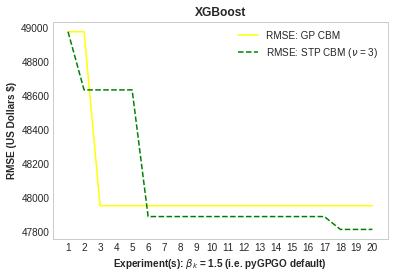

In [66]:
### Visualise!

title = obj_func
plt.figure()

plt.plot(min_rmse_gp, color = 'Yellow', label='RMSE: GP CBM')
plt.plot(min_rmse_stp, color = 'Green', ls='--', label='RMSE: STP CBM ' r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold')
plt.xlabel('Experiment(s): 'r'$\beta_{k}$' ' = 1.5 (i.e. pyGPGO default)', weight = 'bold') # x-axis label
plt.ylabel('RMSE (US Dollars $)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(min_rmse_gp)
plt.xticks(np.arange(count), np.arange(1, count + 1))
plt.grid(b=None)
plt.show() #visualise!


In [67]:
time_gp, time_stp


(618.3255527019501, 649.101037979126)

In [68]:
min(min_rmse_stp), min(min_rmse_gp)


(47814.5922880461, 47953.52149217697)